# RepeatLab

Estimate repeat expansion size and structure easily from your own long-read DNA data produced by Oxford Nanopore DNA sequencing. You can find more details at the <a href="#Instructions">bottom</a> of this notebook.

##Quick Start <a name="Quick Start"></a>
- Follow the instructions of number ⭐ **1.**, ⭐ **2.**, and ⭐ **3.** below.

In [1]:

#@markdown ⭐ **1. Copy the folder containing POD5, FAST5, or FASTQ files into your Google Drive, and write down the location below.** \
#@markdown - POD5 or FAST5 file format is recommended as input.
#@markdown - The `data_dir` must be under the `MyDrive` directory.  <a name="data_dir"></a>

data_type = "pod5" #@param ["pod5", "fast5", "fastq"]
data_dir = "Colab_Notebooks/data/NA03697_test/" #@param {type:"string"}
#output_dir = "Colab Notebooks/outputs/test" #@param {type:"string"}
pore_type = "r9.4.1" #@param ["r9.4.1", "r10.4.1"]


#@markdown \
#@markdown ⭐ **2. Write down your sample name and target gene name. Sample name will be printed in your report.** \


sample_name = "NA03697" #@param {type:"string"}
target_gene = "DMPK" #@param ["DMPK", "CNBP", "NOP56", "None"]
target_gene_lower = f'{target_gene}'.lower()

NEW_TARGET = False
#@markdown - If there is NO target you want, then add new targets <a href="#Add Target">below</a>. \

#@markdown \
#@markdown ⭐ **3. Click the button `Runtime` tab > `Run all` (or just hit '`command`/`control` + `F9`' as keyboard shortcut).**
#@markdown
#@markdown - Sign in to your own Google account if pop-up appears or press `Continue` if the account is already connected.

## Custom option setting
##### Click to expand custom & advanced setting cells.

In [2]:
#@title (Advanced) Input parameters
#@markdown You can change Dorado basecaller version. You can just keep the defualt options for your first run.

dorado_version = "0.4.1" #@param ["0.3.0", "0.3.1", "0.3.2", "0.4.0", "0.4.1"]

if pore_type == 'r9.4.1':
  dorado_model = "dna_r9.4.1_e8_sup@v3.6"
  dorado_rough_model = "dna_r9.4.1_e8_fast@v3.4"
  dorado_original_model = "dna_r9.4.1_e8_sup@v3.3"
  if dorado_version.startswith('0.3'):
    dorado_5mC_model = "dna_r9.4.1_e8_sup@v3.3_5mCG@v0"
  elif dorado_version.startswith('0.4'):
    dorado_5mC_model = "dna_r9.4.1_e8_sup@v3.3_5mCG@v0.1"

#@markdown Translocation speed information is needed only for R10.4.1 pore. Just ignore this section for R9.4.1.
if pore_type == 'r10.4.1':
  translocation_speed = "260bps" #@param ["260bps", "400bps"]
  if translocation_speed == "260bps":
    dorado_model = "dna_r10.4.1_e8.2_260bps_sup@v4.1.0"
    dorado_rough_model = "dna_r10.4.1_e8.2_260bps_fast@v4.1.0"
    dorado_5mC_model = "dna_r10.4.1_e8.2_260bps_sup@v3.5.2_5mCG@v2"
    dorado_original_model = "dna_r10.4.1_e8.2_260bps_sup@v3.5.2"
  elif translocation_speed == "400bps":
    dorado_model = "dna_r10.4.1_e8.2_400bps_sup@v4.1.0"
    dorado_rough_model = "dna_r10.4.1_e8.2_400bps_fast@v4.1.0"
    dorado_5mC_model = "dna_r10.4.1_e8.2_400bps_sup@v3.5.2_5mCG@v2"
    dorado_original_model = "dna_r10.4.1_e8.2_400bps_sup@v3.5.2"

# dorado_model = "dna_r9.4.1_e8_sup@v3.6" #@param ["dna_r9.4.1_e8_fast@v3.4", "dna_r9.4.1_e8_hac@v3.3", "dna_r9.4.1_e8_sup@v3.3", "dna_r9.4.1_e8_sup@v3.6", "dna_r10.4.1_e8.2_260bps_fast@v4.1.0", "dna_r10.4.1_e8.2_260bps_hac@v4.1.0", "dna_r10.4.1_e8.2_260bps_sup@v4.1.0", "dna_r10.4.1_e8.2_400bps_fast@v4.1.0", "dna_r10.4.1_e8.2_400bps_hac@v4.1.0", "dna_r10.4.1_e8.2_400bps_sup@v4.1.0"] {allow-input: true}
# dorado_rough_model =
# dorado_5mC_model = "dna_r9.4.1_e8_sup@v3.3_5mCG@v0" #@param ["dna_r9.4.1_e8_fast@v3.4_5mCG@v0", "dna_r9.4.1_e8_hac@v3.3_5mCG@v0", "dna_r9.4.1_e8_sup@v3.3_5mCG@v0"]
# dorado_original_model = dorado_5mC_model[:-8]

minimap2_options = "-w 20 -s 40 -k 13"

In [3]:
#@title (Advanced) Barcode demultiplexing
#@markdown - If the sample data is multiplexed using barcodes, check this box and choose the kit and the barcode number.
#@markdown - Dorado version >= 0.4.0 is needed for barcode demultiplexing. Please adjust the `dorado_version` at the upper cell for use.

barcode_multiplexing = False #@param {type:"boolean"}
barcode_kit = "EXP-NBD104" #@param ["EXP-NBD103", "EXP-NBD104", "EXP-NBD114","EXP-NBD196","EXP-PBC001", "EXP-PBC096", "SQK-16S024", "SQK-16S114-24", "SQK-LWB001", "SQK-MLK111-96-XL", "SQK-MLK114-96-XL", "SQK-NBD111-24","SQK-NBD111-96","SQK-NBD112-24", "SQK-NBD112-96", "SQK-NBD114-24", "SQK-NBD114-96", "SQK-PBK004", "SQK-PCB109", "SQK-PCB110", "SQK-PCB111-24", "SQK-PCB114-24", "SQK-RAB201", "SQK-RAB204", "SQK-RBK001", "SQK-RBK004", "SQK-RBK110-96", "SQK-RBK111-24", "SQK-RBK111-96", "SQK-RBK112-24", "SQK-RBK112-96", "SQK-RBK114-24", "SQK-RBK114-96", "SQK-RLB001", "SQK-RPB004", "SQK-RPB114-24", "VSK-PTC001", "VSK-VMK001", "VSK-VMK004", "VSK-VPS001"]
barcode_number = 1 # @param {type:"integer"}
if barcode_number < 10:
  barcode_num = 'barcode0' + str(barcode_number)
else:
  barcode_num = 'barcode' + str(barcode_number)

In [4]:
#@title (Optional) Add a new target <a name="Add Target"></a>
#@markdown Check the box and fill in the repeat information if you want to use this as a new target which is not in the `target_gene` lists.
NEW_TARGET = False #@param {type:"boolean"}
if NEW_TARGET == True:
  target_gene = "" #@param {type:"string"}
  #@markdown Repeat location
  chromosome = "chr1" #@param ["chr1", "chr2", "chr3", "chr4", "chr5", "chr6", "chr7", "chr8", "chr9", "chr10", "chr11", "chr12", "chr13", "chr14", "chr15", "chr16", "chr17", "chr18", "chr19", "chr20", "chr21", "chr22", "chrX", "chrY"]
  start_position = 0 #@param {type:"integer"}
  end_position = 0 #@param {type:"integer"}
  strand = "+" #@param ["+", "-"]
  copy_number = 0 #@param {type:"integer"}
  #@markdown Repeat pattern
  repeat_pattern = "" #@param {type:"string"}

In [5]:
#@title (Optional) Methylation rate check sites
#@markdown - Write down the positions of the CpG sites for which you want to specifically calculate the methylation rate. The sites should be listed and separated by commas (,) without any spaces ( ).(ONLY sites without chromosome number)
#@markdown
#@markdown    (e.g. 45768652,45768667)

#@markdown - If you want to designate each key regions with multiple CpG sites, you can make groups of loci. CpG sites within the same group should be separated by commas (,), and different groups should be separated by a single space ( ).
#@markdown
#@markdown    (e.g. 45768652,45768667,45768673 45770725,45770739 45769906,45769912,45769924)

#@markdown - If you selected DMPK as a target gene, CpG sites have already been entered. You don't need to write any text.

if target_gene == "DMPK":
  methylation_key_positions = "45768652,45768667,45768673,45768678,45768682,45768687 45770725,45770739,45770744,45770750,45770784,45770788 45769906,45769912,45769924,45769933,45769951,45769953"
  CTCF1_positions = "45770307,45770328,45770332,45770342,45770348,45770371,45770381,45770385,45770390,45770408,45770415,45770417,45770429,45770436,45770455,45770463,45770469,45770495,45770497,45770501,45770512,45770515,45770525,45770537,45770540"
  CTCF2_positions = "45769994,45770013,45770015,45770022,45770039,45770068,45770076,45770091,45770107,45770111,45770116"
else:
  methylation_key_positions = "" #@param {type:"string"}

# Running

In [6]:
#@title Mounting your Google Drive

#@markdown - Connecting this Colab to your own Google Drive. This process makes it available to manage your input or output data conveniently.
#@markdown - Please allow the accesesion to your accounts' Google Drive.
#@markdown - `OUTPUT` : a directory (folder) of your sample name for results. (You can find it in `MyDrive/repeatlab/analysis/'sample_name'`.)
#@markdown - `ERROR` : \
#@markdown    a. `FileNotFoundError` : Check if you put your fast5 data exactly in <a href="#data_dir">`data_dir`</a> that you wrote. \


from google.colab import drive
import os, os.path

DRIVE_PREFIX = '/content/drive'
DRIVE_ROOT = os.path.join(DRIVE_PREFIX, 'MyDrive')
WORK_DIR = os.path.join(DRIVE_ROOT, 'repeatlab')
SYS_DIR = os.path.join(DRIVE_ROOT, 'repeatlab', 'sys')
#OUTPUT_DIR = os.path.join(DRIVE_ROOT, output_dir)
INPUT_DIR = os.path.join(DRIVE_ROOT, data_dir)
OUTPUT_DIR_S = os.path.join(DRIVE_ROOT, 'repeatlab', 'analysis', f'{sample_name}')
OUTPUT_DIR_T = os.path.join(DRIVE_ROOT, 'repeatlab', 'analysis', f'{sample_name}', f'{sample_name}-{target_gene}')

if not os.path.isdir(DRIVE_ROOT):
  drive.mount(DRIVE_PREFIX)

if not os.path.isdir(INPUT_DIR):
  raise FileNotFoundError(f"Input directory {INPUT_DIR} is not accessible.")

if not os.path.isdir(SYS_DIR):
  os.makedirs(SYS_DIR)

if not os.path.isdir(OUTPUT_DIR_S):
  os.makedirs(OUTPUT_DIR_S)

if not os.path.isdir(OUTPUT_DIR_T):
  os.makedirs(OUTPUT_DIR_T)

print('DONE')

Mounted at /content/drive
DONE


## Part A. - Install
#### This part is necessary for your first run only. It will be automately skipped for multi-time runs.

In [7]:
#@markdown
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
#@title Downloading and importing python modules

#@markdown - Downloading some python modules necessary for calculating, data formatting or plotting.
#@markdown - It takes a few minutes for the first time.
#@markdown - If pop-up comes up with warning message, please press 'Cancel'.

import warnings
warnings.filterwarnings("ignore", message="The following packages were previously imported in this runtime:")

try:
  import aplanat
except ImportError:
  !pip install aplanat==0.6.16
  import aplanat

try:
  import epi2melabs
except ImportError:
  !pip install epi2melabs==0.0.55
  import epi2melabs

try:
  import pyranges
except ImportError:
  !pip install pyranges==0.1.2
  import pyranges

try:
  import pysam
except ImportError:
  !pip install pysam==0.22.1
  import pysam

try:
  import alv
except ImportError:
  !pip install alv==1.7.2
  import alv

try:
  import pod5
except ImportError:
  import warnings
  warnings.filterwarnings("ignore", category=UserWarning, module="pyarrow")
  !pip install pod5==0.3.11
  import pod5

#if not os.path.isdir('/usr/local/lib/python3.7/dist-packages/aplanat'):
#  !pip install aplanat

#if not os.path.isdir('/usr/local/lib/python3.7/dist-packages/epi2melabs'):
#  !pip install epi2melabs

#if not os.path.isdir('/usr/local/lib/python3.7/dist-packages/pyranges'):
#  !pip install pyranges


import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
from sklearn.mixture import GaussianMixture

import aplanat
import aplanat.report
import aplanat.graphics
from aplanat import annot, lines, util
from epi2melabs.notebook import InputForm, InputSpec
import ipywidgets as widgets

from bokeh.layouts import gridplot
from bokeh.models import Legend



print('DONE')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.5/297.5 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.4/161.4 kB 18.6 MB/s eta 0:00:00
  Created wheel for aplanat: filename=aplanat-0.6.16-py3-none-any.whl size=306796 sha256=b99dd154ea615d56392ed7db511970347421e6e9ae9aaa21ae75f30d519aff4b
  Stored in directory: /root/.cache/pip/wheels/07/58/e0/15999d151176f84fa6a6f41ff4eb05fb5443807d9ea4f6d53b
  Created wheel for tinycss: filename=tinycss-0.4-cp311-cp311-linux_x86_64.whl size=328284 sha256=017e570c4e4011298a49021017f635308a91bcce9dcf3d035d8c2ef505d5a2a2
  Stored in directory: /root/.cache/pip/wheels/57/c0/0f/7ed6f1bfca35d165d4979934ee25cf1273ab20a62e72325dfd
Successfully built aplanat tinycss
  Attempting uninstall: bokeh

/usr/local/lib/python3.11/dist-packages/pyranges/__init__.py:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.1/25.1 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 17.0.0
    Uninstalling pyarrow-17.0.0:
      Successfully uninstalled pyarrow-17.0.0
  Attempting uninstall: polars
    Found existing installation: polars 1.9.0
    Uninstalling polars-1.9.0:
      Successfully uninstalled polars-1.9.0
  Attempting uninstall: h5py
    Found existing installation: h5p

DONE


In [9]:
#@title Preparing conda environment for analysis

#@markdown - A conda environment is needed to control collision between tools' different version.

if not os.path.isdir('/content/colab-biolab'):
  %cd /content
  !git clone https://github.com/hyeshik/colab-biolab.git
  !cd colab-biolab && bash tools/setup.sh


CONDABIN = '/root/conda/bin'
if CONDABIN not in os.environ['PATH'].split(':'):
  os.environ['PATH'] += ':' + CONDABIN

if not os.path.exists(os.path.join(CONDABIN, 'mamba')):
  !conda install -y -n base -c conda-forge mamba

print('DONE')

/content
Cloning into 'colab-biolab'...


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 76 (delta 26), reused 59 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 318.16 KiB | 449.00 KiB/s, done.
Resolving deltas: 100% (26/26), done.
./
./root/
./root/.profile
./root/.condarc
./root/.bin.priority/
./root/.bin.priority/pip
./root/.bin.priority/pip2
./root/.bin.priority/pip3
./root/.tmux.conf
./root/.bashrc.biolab
./root/.vimrc
--2025-01-23 16:29:15--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147784736 (141M) [application/octet-stream]
Saving to: ‘miniconda3.sh’

miniconda3.sh       100%[===================>] 140.94M   223MB/s    in 0.6s 

In [10]:
#@title Installing RepeatHMM

#@markdown - RepeatHMM is a tool for counting repeats in long-read sequencing data.
#@markdown - https://doi.org/10.1186/s13073-017-0456-7 \
#@markdown   Liu, Q., Zhang, P., Wang, D. et al. Interrogating the “unsequenceable” genomic trinucleotide repeat disorders by long-read sequencing. *Genome Med* 9, 65 (2017). \
#@markdown - `OUTPUT` : a directory of RepeatHMM source codes. (You can find it in `MyDrive/repeatlab/sys/RepeatHMM`.)


REPEATHMM_DIR = os.path.join(SYS_DIR, 'RepeatHMM')
if not os.path.isdir(REPEATHMM_DIR):
  parentdir = os.path.dirname(REPEATHMM_DIR)
  !cd $parentdir && git clone https://github.com/WGLab/RepeatHMM
  #!cd $REPEATHMM_DIR && curl https://yoojung.qbio.io/repeat-expansion/repeathmm-structure-dump.diff | patch -p1
  # !cd $REPEATHMM_DIR && curl https://yoojung.qbio.io/repeat-expansion/repeathmm-environment.diff > repeathmm-environment.diff
  # !patch -p1 < repeathmm-environment.diff

while not os.path.exists(f'{REPEATHMM_DIR}/repeathmm-environment.diff') or os.path.getsize(f'{REPEATHMM_DIR}/repeathmm-environment.diff') == 0:
  print('=> Downloading env diff file..')
  !cd $REPEATHMM_DIR && curl https://yoojung.qbio.io/repeat-expansion/repeathmm-environment.diff > repeathmm-environment.diff
  !patch -p0 environment.yml repeathmm-environment.diff

if not os.path.isdir('/root/conda/envs/rhmm'):
  !cd $REPEATHMM_DIR && patch -p0 environment.yml repeathmm-environment.diff
  !conda env create -n rhmm -f $REPEATHMM_DIR/environment.yml
  !conda install -n rhmm -y swig
  !cd /root/conda/envs/rhmm/lib && ln -s libcrypto.so.1.1 libcrypto.so.1.0.0
  !cd $REPEATHMM_DIR/bin/RepeatHMM_scripts/UnsymmetricPairAlignment && conda run -n rhmm --no-capture-output make

pattern_file = os.path.join(REPEATHMM_DIR, 'bin', 'reference_sts', 'hg38', 'hg38.predefined.pa')

if NEW_TARGET == True:
  new_target_line = target_gene.lower() + ',' + chromosome + ',' + str(start_position) + ',' + str(end_position) + ',' + repeat_pattern.upper() + ',' + strand+str(copy_number) + ',' + '' + ',' + ''
  !echo $new_target_line >> $pattern_file
  target_gene = target_gene.upper()

while not os.path.exists(f'{REPEATHMM_DIR}/repeathmm-structure-dump.diff') or os.path.getsize(f'{REPEATHMM_DIR}/repeathmm-structure-dump.diff') == 0:
  print('=> Downloading code diff file..')
  !cd $REPEATHMM_DIR && curl https://yoojung.qbio.io/repeat-expansion/repeathmm-structure-dump.diff > repeathmm-structure-dump.diff
  !cd $REPEATHMM_DIR/bin && patch -p2 < ../repeathmm-structure-dump.diff

print('DONE')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


patching file environment.yml
patch unexpectedly ends in middle of line
Reversed (or previously applied) patch detected!  Assume -R? [n] 
Apply anyway? [n] 
Skipping patch.
1 out of 1 hunk ignored -- saving rejects to file environment.yml.rej
Channels:
 - conda-forge
 - bioconda
 - anaconda
 - defaults
Platform: linux-64
Solving environment: | / done

mkl-2018.0.3         | 198.7 MB  | :   0% 0/1 [00:00<?, ?it/s]
scipy-1.1.0          | 17.9 MB   | :   0% 0/1 [00:00<?, ?it/s]

perl-5.26.2          | 15.9 MB   | :   0% 0/1 [00:00<?, ?it/s]


python-2.7.18        | 12.7 MB   | :   0% 0/1 [00:00<?, ?it/s]



libgcc-ng-9.1.0      | 8.1 MB    | :   0% 0/1 [00:00<?, ?it/s]




scikit-learn-0.19.2  | 5.3 MB    | :   0% 0/1 [00:00<?, ?it/s]





libstdcxx-ng-9.1.0   | 4.0 MB    | :   0% 0/1 [00:00<?, ?it/s]






openssl-1.1.1u       | 3.8 MB    | :   0% 0/1 [00:00<?, ?it/s]







tk-8.6.8             | 3.1 MB    | :   0% 0/1 [00:00<?, ?it/s]








numpy-1.12.1         | 3.0 MB    | :   

In [11]:
#@title Installing other genome data processing tools

#@markdown - Downloading samtools, bedtools, seqtk, and pomoxis for data processing.

if not os.path.isdir('/root/conda/envs/lab'):
  # !mamba create -y -n lab samtools bedtools seqtk htslib
  !conda create -y -n lab samtools bedtools seqtk htslib
if not os.path.isdir('/root/conda/envs/ont_analysis'):
  # !mamba create -y -n ont_analysis pomoxis
  !conda create -y -n ont_analysis pomoxis
if not os.path.isdir('/root/conda/envs/minimap2'):
  # !mamba create -y -n minimap2 minimap2
  !conda create -y -n minimap2 minimap2

lab_command_prefix = 'conda run -n lab --no-capture-output'
ont_command_prefix = 'conda run -n ont_analysis --no-capture-output'
minimap2_command_prefix = 'conda run -n minimap2 --no-capture-output'

print('DONE')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Channels:
 - conda-forge
 - bioconda
 - defaults
Platform: linux-64
Solving environment: | done

## Package Plan ##

  environment location: /root/conda/envs/lab

  added / updated specs:
    - bedtools
    - htslib
    - samtools
    - seqtk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bedtools-2.31.1            |       h13024bc_3         1.5 MB  bioconda
    bzip2-1.0.8                |       h4bc722e_7         247 KB  conda-forge
    c-ares-1.34.4              |       hb9d3cd8_0         201 KB  conda-forge
    htslib-1.21                |       h566b1c6_1         3.0 MB  bioconda
    keyutils-1.6.1             |       h166bdaf_0         115 KB  conda-forge
    krb5-1.21.3                |       h659f571_0         1.3 MB  conda-forge
    libcurl-8.11.1             |       h332b0f4_0         413 KB  conda-forge
    libdeflate-1.23            |       h4ddbbb0_0          71 KB  con

In [12]:
#@markdown
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
#@title Installing ONT Dorado

#@markdown - Downloading Dorado, a basecaller for Oxford Nanopore raw signal data.

# if data_type == 'pod5' or data_type == 'fast5':
dorado_top_dir = os.path.join(SYS_DIR, f'dorado-{dorado_version}-linux-x64')
dorado = os.path.join(dorado_top_dir, 'bin', 'dorado')

if not os.path.exists(dorado):
  URL=f"https://cdn.oxfordnanoportal.com/software/analysis/dorado-{dorado_version}-linux-x64.tar.gz"
  print(f"=> Downloading dorado {dorado_version} from {URL}")
  !curl -L $URL | tar -C $SYS_DIR -xzf -
  !mkdir "$dorado_top_dir/basecalling_models"
  !chmod 755 $dorado

if not os.path.exists(f'{dorado_top_dir}/basecalling_models/{dorado_model}'):
  print(f'=> Downloading dorado basecalling model')
  !$dorado download --model "$dorado_model" --directory "$dorado_top_dir/basecalling_models"
  !$dorado download --model "$dorado_rough_model" --directory "$dorado_top_dir/basecalling_models"
if not os.path.exists(f'{dorado_top_dir}/basecalling_models/{dorado_5mC_model}'):
  print(f'=> Downloading dorado 5mC basecalling model')
  !$dorado download --model "$dorado_5mC_model" --directory "$dorado_top_dir/basecalling_models"
  !$dorado download --model "$dorado_original_model" --directory "$dorado_top_dir/basecalling_models"
  # !$dorado download --directory "$dorado_top_dir/basecalling_models"
print('DONE')
!chmod 755 $dorado
!$dorado --version

DONE
0.4.1+6c4c636


In [14]:
#@title Installing ONT modkit

#@markdown - Downloading modkit, a program for methylation profile data processing.

modkit = os.path.join(SYS_DIR, 'dist', 'modkit')

if not os.path.exists(modkit):
  URL="https://github.com/nanoporetech/modkit/releases/download/v0.1.11/modkit_v0.1.11_centos7_x86_64.tar.gz"
  print(f'=> Downloading modit from {URL}')
  !curl -L $URL | tar -C $SYS_DIR -xzf -
  !chmod 755 $modkit
print('DONE')
!chmod 755 $modkit
!$modkit --version

DONE
mod_kit 0.1.11


In [15]:
#@title Preparing the reference genome sequence

#@markdown - Downloading the reference genome sequence (GRCh38) from Gencode and indexing. \
#@markdown - The reference genome is needed for mapping sequencing data.

REFERENCE_GENOME = 'https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_44/GRCh38.p14.genome.fa.gz'

!mkdir -p $WORK_DIR/references
refgenome_fasta = os.path.join(WORK_DIR, 'references', 'genome.fa.gz')
refgenome_fai = os.path.join(WORK_DIR, 'references', 'genome.fa.gz.fai')
refgenome_index = os.path.join(WORK_DIR, 'references', 'genome.mm2.idx')
refgenome_index_w30 = os.path.join(WORK_DIR, 'references', 'genome_w30.mm2.idx')

if not os.path.exists(refgenome_fasta):
  print('=> Downloading the reference genome')
  !curl $REFERENCE_GENOME | zcat - | $lab_command_prefix \
    bgzip -c > $refgenome_fasta

if not os.path.exists(refgenome_fai):
  !$lab_command_prefix samtools faidx $refgenome_fasta

if not os.path.exists(refgenome_index):
  print('Building minimap2 index..')
  !zcat $refgenome_fasta | $minimap2_command_prefix minimap2 -x map-ont $minimap2_options -d $refgenome_index /dev/stdin

if not os.path.exists(refgenome_index_w30):
  print('Building minimap2 index for rough alignment..')
  !zcat $refgenome_fasta | $minimap2_command_prefix minimap2 -x map-ont -w 30 -k 20 -d $refgenome_index_w30 /dev/stdin

print('DONE')

DONE


## Part B. - Run RepeatLab
#### Running RepeatLab workflows for your each samples.

In [16]:
#@title Checking input directory

#@markdown - Counting how many files in the input `data_dir`.

# Check the FAST5 or FASTQ source dir for the existence and number of files.
data_dir_top = os.path.join(DRIVE_ROOT, data_dir)
if not os.path.isdir(data_dir_top):
  raise FileNotFoundError(f'Data not accessible from {data_dir}')

def count_input_files(topdir):
  pod5_matches = []
  fast5_matches = []
  fastq_matches = []
  fastq_zip_matches = []
  for path, dirs, files in os.walk(topdir):
    for f in files:
      if f.lower().endswith('.fast5'):
        fast5_matches.append(os.path.join(path, f))
      elif f.lower().endswith('.pod5'):
        pod5_matches.append(os.path.join(path, f))
      elif f.lower().endswith('.fastq') or f.lower().endswith('.fq'):
        fastq_matches.append(os.path.join(path, f))
      elif f.lower().endswith('fastq.gz') or f.lower().endswith('.fq.gz'):
        fastq_zip_matches.append(os.path.join(path, f))
  return len(pod5_matches), len(fast5_matches), len(fastq_matches), len(fastq_zip_matches)

num_pod5_files, num_fast5_files, num_fastq_files, num_fastq_zip_files = count_input_files(data_dir_top)[0], count_input_files(data_dir_top)[1], count_input_files(data_dir_top)[2], count_input_files(data_dir_top)[3]
if np.any([num_pod5_files, num_fast5_files, num_fastq_files, num_fastq_zip_files]) == False:
  raise FileNotFoundError(f'No input file is found from {data_dir}')

if data_type == 'fast5':
  print(f'=> {num_fast5_files} FAST5 files are found.')
  if not os.path.isdir(f'{data_dir_top}/pod5'):
    print(f'=> FAST5 to POD5 conversion started..')
    !pod5 convert fast5 "$data_dir_top/" -r --output "$data_dir_top/pod5/" --one-to-one "$data_dir_top/"
    print(f'=> {num_fast5_files} FAST5 files are coverted to POD5 files successfully.')
  else:
    print(f'=> The FAST5 files were converted to POD5 files already.')

elif data_type == 'pod5':
  print(f'=> {num_pod5_files} POD5 files are found.')
elif data_type == 'fastq':
  fastq_zip = os.path.join(OUTPUT_DIR_S, 'basecall.fastq.gz')
  print(f'=> {num_fastq_files} FASTQ files are found')
  if not os.path.exists(fastq_zip):
    if num_fastq_files >= 1 and num_fastq_zip_files == 0:
      !cat $(find "$data_dir_top" -name '*.fastq') | gzip -c /dev/stdin > $fastq_zip
      print('FASTQ files are gzipped into one FASTQ file.')
    elif num_fastq_zip_files >= 1:
      !zcat $(find "$data_dir_top" -name '*.fastq.gz') | gzip -c /dev/stdin > $fastq_zip
  print(f'=> {num_fastq_zip_files} zipped FASTQ files are found.')

=> 1 POD5 files are found.


In [17]:
#@title Extracting on-target reads

#@markdown - Roughly basecall

if not os.path.exists(f'{OUTPUT_DIR_S}/dorado'):
  !mkdir -p $OUTPUT_DIR_S/dorado

rough_basecall_output = os.path.join(OUTPUT_DIR_S, 'dorado', 'roughly-basecalled.bam')
DEMUX_DIR = os.path.join(OUTPUT_DIR_S, 'dorado', 'demux')
rough_basecall_demux_output = os.path.join(OUTPUT_DIR_S, 'dorado', 'demux', f'{barcode_kit}_{barcode_num}.bam')
rough_basecall_output_fastq = os.path.join(OUTPUT_DIR_S, 'dorado', 'roughly-basecalled.fastq.gz')
rough_align_output = os.path.join(OUTPUT_DIR_S, 'dorado', 'roughly-aligned.bam')
rough_basecall_summary = os.path.join(OUTPUT_DIR_S, 'dorado', 'roughly-basecalled.summary.txt')
rough_align_sorted_output = os.path.join(OUTPUT_DIR_S, 'dorado', 'roughly-aligned.sorted.bam')
rough_align_output_index = os.path.join(OUTPUT_DIR_S, 'dorado', 'roughly-aligned.sorted.bam.bai')

if not os.path.exists(OUTPUT_DIR_T):
  !mkdir -p $OUTPUT_DIR_T

align_output = os.path.join(OUTPUT_DIR_T, 'dorado', 'aligned.bam')
align_output_sorted = os.path.join(OUTPUT_DIR_T, 'dorado', 'aligned.sorted.bam')
align_output_sorted_index = os.path.join(OUTPUT_DIR_T, 'dorado', 'aligned.sorted.bam.bai')

ontarget_readID_list = os.path.join(OUTPUT_DIR_T, 'on-target_readIDs.txt')

if NEW_TARGET == False:
  pattern_file = os.path.join(REPEATHMM_DIR, 'bin', 'reference_sts', 'hg38', 'hg38.predefined.pa')
  with open(pattern_file) as pat_file:
    for line in pat_file:
      region_info = line.split(',')
      if region_info[0] == target_gene_lower:
        chr = str(region_info[1])
        start_pos = int(region_info[2]) - 5000
        end_pos = int(region_info[3]) + 5000
  target_region = chr + ':' + str(start_pos) + '-' + str(end_pos)
else:
  target_region = chromosome + ':' + str(start_position) + '-' + str(end_position)

if barcode_multiplexing == False:
  if data_type == 'pod5':
    if not os.path.exists(rough_basecall_output):
      print('=> Basecalling started..')
      !$dorado basecaller -x cuda:all --emit-sam -r \
      "$dorado_top_dir/basecalling_models/$dorado_rough_model/" "$data_dir_top/" | $lab_command_prefix samtools view -b -o $rough_basecall_output
    if not os.path.exists(rough_basecall_summary):
      !$dorado summary $rough_basecall_output > $rough_basecall_summary
    if not os.path.exists(rough_align_output):
      !$dorado aligner -t 5 -I 6G -k 20 -w 30 $refgenome_index_w30 $rough_basecall_output > $rough_align_output
    if not os.path.exists(rough_align_sorted_output):
      !$lab_command_prefix samtools sort -o $rough_align_sorted_output $rough_align_output
    if not os.path.exists(rough_align_output_index):
      !$lab_command_prefix samtools index $rough_align_sorted_output
    if not os.path.exists(ontarget_readID_list):
      !$lab_command_prefix samtools view $rough_align_sorted_output "$target_region" | cut -f1 | sort | uniq > $ontarget_readID_list

  elif data_type == 'fast5':
    if not os.path.exists(rough_basecall_output):
      print('=> Basecalling started..')
      !$dorado basecaller -x cuda:all --emit-sam -r \
      "$dorado_top_dir/basecalling_models/$dorado_rough_model/" "$data_dir_top/pod5/" | $lab_command_prefix samtools view -b -o $rough_basecall_output
    if not os.path.exists(rough_basecall_summary):
      !$dorado summary $rough_basecall_output > $rough_basecall_summary
    if not os.path.exists(rough_align_output):
      !$dorado aligner -t 5 -I 6G -k 20 -w 30 $refgenome_index_w30 $rough_basecall_output > $rough_align_output
    if not os.path.exists(rough_align_sorted_output):
      !$lab_command_prefix samtools sort -o $rough_align_sorted_output $rough_align_output
    if not os.path.exists(rough_align_output_index):
      !$lab_command_prefix samtools index $rough_align_sorted_output
    if not os.path.exists(ontarget_readID_list):
      !$lab_command_prefix samtools view $rough_align_sorted_output "$target_region" | cut -f1 | sort | uniq > $ontarget_readID_list

  elif data_type == 'fastq':
    print('=> Alignment started..')
    if not os.path.exists(rough_align_output):
      !$dorado aligner -t 5 -I 6G -k 20 -w 30 $refgenome_index_w30 $fastq_zip > $rough_align_output
    if not os.path.exists(rough_align_sorted_output):
      !$lab_command_prefix samtools sort -o $rough_align_sorted_output $rough_align_output
    if not os.path.exists(rough_align_output_index):
      !$lab_command_prefix samtools index $rough_align_sorted_output
    if not os.path.exists(align_output):
      !$lab_command_prefix samtools view $rough_align_sorted_output "$target_region" -b > $align_output
    if not os.path.exists(align_output_sorted):
      !$lab_command_prefix samtools sort -o $align_output_sorted $align_output
    if not os.path.exists(align_output_sorted_index):
      !$lab_command_prefix samtools index $align_output_sorted


elif barcode_multiplexing == True:
  if data_type == 'pod5':
    if not os.path.exists(rough_basecall_output):

      print('=> Basecalling started..')
      !$dorado basecaller -x cuda:all --emit-sam -r \
      "$dorado_top_dir/basecalling_models/$dorado_rough_model/" "$data_dir_top/" | $lab_command_prefix samtools view -b -o $rough_basecall_output
    if not os.path.isdir(DEMUX_DIR):
      os.makedirs(DEMUX_DIR)
    if not os.path.exists(rough_basecall_demux_output):
      !$dorado demux --kit-name $barcode_kit --output-dir $DEMUX_DIR $rough_basecall_output
    if not os.path.exists(rough_basecall_summary):
      !$dorado summary $rough_basecall_demux_output > $rough_basecall_summary
    if not os.path.exists(rough_align_output):
      !$dorado aligner -t 5 -I 6G -k 20 -w 30 $refgenome_index_w30 $rough_basecall_demux_output > $rough_align_output
    if not os.path.exists(rough_align_sorted_output):
      !$lab_command_prefix samtools sort -o $rough_align_sorted_output $rough_align_output
    if not os.path.exists(rough_align_output_index):
      !$lab_command_prefix samtools index $rough_align_sorted_output
    if not os.path.exists(ontarget_readID_list):
      !$lab_command_prefix samtools view $rough_align_sorted_output "$target_region" | cut -f1 | sort | uniq > $ontarget_readID_list

  elif data_type == 'fast5':
    if not os.path.exists(rough_basecall_output):
      print('=> Basecalling started..')
      !$dorado basecaller -x cuda:all --emit-sam -r \
      "$dorado_top_dir/basecalling_models/$dorado_rough_model/" "$data_dir_top/pod5/" | $lab_command_prefix samtools view -b -o $rough_basecall_output
    if not os.path.isdir(DEMUX_DIR):
      os.makedirs(DEMUX_DIR)
    if not os.path.exists(rough_basecall_demux_output):
      !$dorado demux --kit-name $barcode_kit --output-dir $DEMUX_DIR $rough_basecall_output
    if not os.path.exists(rough_basecall_summary):
      !$dorado summary $rough_basecall_demux_output > $rough_basecall_summary
    if not os.path.exists(rough_align_output):
      !$dorado aligner -t 5 -I 6G -k 20 -w 30 $refgenome_index_w30 $rough_basecall_demux_output > $rough_align_output
    if not os.path.exists(rough_align_sorted_output):
      !$lab_command_prefix samtools sort -o $rough_align_sorted_output $rough_align_output
    if not os.path.exists(rough_align_output_index):
      !$lab_command_prefix samtools index $rough_align_sorted_output
    if not os.path.exists(ontarget_readID_list):
      !$lab_command_prefix samtools view $rough_align_sorted_output "$target_region" | cut -f1 | sort | uniq > $ontarget_readID_list

  elif data_type == 'fastq':
    if not os.path.isdir(DEMUX_DIR):
      os.makedirs(DEMUX_DIR)
    if not os.path.exists(rough_basecall_demux_output):
      !$dorado demux --kit-name $barcode_kit --output-dir $DEMUX_DIR $fastq_zip
    if not os.path.exists(rough_basecall_summary):
      !$dorado summary $rough_basecall_demux_output > $rough_basecall_summary
    if not os.path.exists(rough_align_output):
      !$dorado aligner -t 5 -I 6G -k 20 -w 30 $refgenome_index_w30 $rough_basecall_demux_output > $rough_align_output
    if not os.path.exists(rough_align_sorted_output):
      !$lab_command_prefix samtools sort -o $rough_align_sorted_output $rough_align_output
    if not os.path.exists(rough_align_output_index):
      !$lab_command_prefix samtools index $rough_align_sorted_output
    if not os.path.exists(align_output):
      !$lab_command_prefix samtools view $rough_align_sorted_output "$target_region" -b > $align_output
    if not os.path.exists(align_output_sorted):
      !$lab_command_prefix samtools sort -o $align_output_sorted $align_output
    if not os.path.exists(align_output_sorted_index):
      !$lab_command_prefix samtools index $align_output_sorted

if os.path.exists(ontarget_readID_list):
  print("=> On-target read IDs extraction successfully completed.")



=> On-target read IDs extraction successfully completed.


In [18]:
#@title Basecalling

#@markdown - Convert raw signal to DNA base. \
#@markdown - `INPUT` : pod5 files or fast5 files that are converted to pod5 files in the input directory `data_dir`. \
#@markdown - `OUTPUT` : fastq files. You can find them at `repeatlab/analysis/[sample_name]/dorado/`.

!mkdir -p $OUTPUT_DIR_T/dorado
basecall_output = os.path.join(OUTPUT_DIR_T, 'dorado', 'basecalled.bam')
# basecall_5mC_output = os.path.join(OUTPUT_DIR_T, 'dorado', 'basecalled_5mC.bam')

if data_type == 'pod5':
  if not os.path.exists(basecall_output):
    print('Basecalling started..')
    !$dorado basecaller -x cuda:all --min-qscore 6 --chunksize 80000 --batchsize 32 \
     --emit-sam -r "$dorado_top_dir/basecalling_models/$dorado_model/" \
     -l $ontarget_readID_list "$data_dir_top/" | $lab_command_prefix samtools view -b -o $basecall_output
  # if not os.path.exists(basecall_5mC_output):
  #   !$dorado basecaller -x cuda:all --min-qscore 6 --chunksize 80000 --batchsize 32 \
  #    --modified-bases-models "$dorado_top_dir/basecalling_models/$dorado_5mC_model/" \
  #    --emit-sam -r "$dorado_top_dir/basecalling_models/$dorado_original_model/" \
  #    -l $ontarget_readID_list "$data_dir_top/" | $lab_command_prefix samtools view -b -o $basecall_5mC_output

elif data_type == 'fast5':
  if not os.path.exists(basecall_output):
    print('Basecalling started..')
    !$dorado basecaller -x cuda:all --min-qscore 6 --chunksize 80000 --batchsize 32 \
     --emit-sam -r "$dorado_top_dir/basecalling_models/$dorado_model/" \
     -l $ontarget_readID_list "$data_dir_top/pod5/" | $lab_command_prefix samtools view -b -o $basecall_output
  # if not os.path.exists(basecall_5mC_output):
  #   !$dorado basecaller -x cuda:all --min-qscore 6 --chunksize 80000 --batchsize 32 \
  #    --modified-bases-models "$dorado_top_dir/basecalling_models/$dorado_5mC_model/" \
  #    --emit-sam --emit-moves -r "$dorado_top_dir/basecalling_models/$dorado_original_model/" \
  #    -l $ontarget_readID_list "$data_dir_top/pod5/" | $lab_command_prefix samtools view -b -o $basecall_5mC_output

elif data_type == 'fastq':
  print('FASTQ input data does not need basecalling.')

print('DONE')

DONE


In [19]:
#@title Mapping the sequence reads

#@markdown - Align sequencing data to reference genome sequence to find where the sequences came from. \
#@markdown - `INPUT` : a bam file basecalled at 'Basecalling' process. \
#@markdown - `OUTPUT` : a sorted bam file, and its index file. You can find it at `repeatlab/analysis/{sample_name}/minimap2`.

align_output = os.path.join(OUTPUT_DIR_T, 'dorado', 'aligned.bam')
align_output_sorted = os.path.join(OUTPUT_DIR_T, 'dorado', 'aligned.sorted.bam')
align_output_sorted_index = os.path.join(OUTPUT_DIR_T, 'dorado', 'aligned.sorted.bam.bai')


if data_type == 'pod5' or data_type == 'fast5':
  if os.path.exists(align_output_sorted):
    print('Alignment already done.')
  else:
    print('Alignment started..')
    print('Alignment takes a few minutes. Please wait.')
    !$dorado aligner -t 5 $refgenome_index $basecall_output | $lab_command_prefix samtools sort -o $align_output_sorted /dev/stdin
    print('Alignment successfully done.')

  if not os.path.exists(align_output_sorted_index):
    !$lab_command_prefix samtools index $align_output_sorted

elif data_type == 'fastq':
  print('FASTQ input data does not need additional mapping.')

print('DONE')

Alignment already done.
DONE


In [20]:
#@title Running RepeatHMM

#@markdown - Running 'RepeatHMM'. \
#@markdown - `INPUT` : a bam file created at 'Mapping' step. \
#@markdown - `OUTPUT` : a result log file which contains information about repeats. \
#@markdown You can find it at `repeatlab/analysis/{sample_name}/{target_gene}/RepeatHMM/rhmm_result.log`.

print('Repeat count calculation started..')

rhmm_output = os.path.join(OUTPUT_DIR_T, 'repeatHMM', 'rhmm_result.log')
tmpdir = os.path.join(OUTPUT_DIR_T, 'tmp')
logbam = 'logbam'
pattern_file = os.path.join(REPEATHMM_DIR, 'bin', 'reference_sts', 'hg38', 'hg38.predefined.pa')
original_output = os.path.join(f'{logbam}/RepBAM_{target_gene}.gmm*.log')

if not os.path.isdir(tmpdir):
  os.makedirs(tmpdir)
if os.path.isdir(logbam):
  !rm -rf $logbam
  os.makedirs(logbam)
if not os.path.exists(rhmm_output):
  !conda run --no-capture-output -n rhmm python2.7 $REPEATHMM_DIR/bin/repeatHMM.py BAMinput --repeatName $target_gene \
  --GapCorrection 1 --FlankLength 30 --UserDefinedUniqID $sample_name-$target_gene \
  --Onebamfile $align_output_sorted --outFolder $tmpdir/ --Patternfile $pattern_file --hgfile $refgenome_fasta --SplitAndReAlign 2 --SeqTech Nanopore --outlog DEBUG
  !mkdir -p $OUTPUT_DIR_T/repeatHMM
  !mv $original_output $rhmm_output

print('DONE')
print(f'Result log file is in {rhmm_output}')

Repeat count calculation started..
DONE
Result log file is in /content/drive/MyDrive/repeatlab/analysis/NA03697/NA03697-DMPK/repeatHMM/rhmm_result.log


In [21]:
#@title Methylation profiling

#@markdown - Align sequences to reference genome before methylation profiling.

from sklearn.mixture import GaussianMixture


if data_type == 'fastq':
  print('FASTQ input does not offer methylation profiling.')

elif data_type == 'pod5' or 'fast5':

  allele1_readID = os.path.join(OUTPUT_DIR_T, 'allele1_readIDs.txt')
  allele2_readID = os.path.join(OUTPUT_DIR_T, 'allele2_readIDs.txt')

  # Clustering the reads for phasing
  NUM_ALLELES = 2
  sample_reads = {}

  with open(rhmm_output) as f:
    for line in f:
      if line.startswith('INFO: READ:'):
        fragments = line.split(' ')
        if fragments[2] == 'Status:True':
          repeat_count = int(fragments[3][11:])
          if repeat_count != 0:
            read_id = fragments[1][5:]
            sequence = fragments[6][7:]
            pattern = fragments[5][9:]
            sample_reads[read_id] = [repeat_count, sequence]

  sample_reads_df = pd.DataFrame(sample_reads).T.reset_index().sort_values(by=[0])
  sample_reads_df.columns = ['read_id', 'repeat_count', 'sequence']
  sample_reads_df.reset_index(drop=True, inplace=True)

  rc = sample_reads_df['repeat_count'].to_list()
  sample_repeats = np.array(rc)
  l10_sample_repeats = np.log10(sample_repeats)
  sample_gmm = GaussianMixture(NUM_ALLELES).fit(l10_sample_repeats[:, np.newaxis])
  gmm_labels = np.argsort(sample_gmm.means_.ravel())
  gmmidx2label = {gmmidx: label for label, gmmidx in enumerate(gmm_labels)}
  gmm_means = sample_gmm.means_[gmm_labels]
  pred_labels = np.array([gmmidx2label[p] for p in sample_gmm.predict(l10_sample_repeats[:, np.newaxis])])
  allele_repeats = 10 ** gmm_means

  sample_reads_df.insert(2, 'allele', pred_labels)

  allele1_reads = sample_reads_df[sample_reads_df['allele'] == 0]['read_id'].to_list()
  allele2_reads = sample_reads_df[sample_reads_df['allele'] == 1]['read_id'].to_list()

  # Write down read IDs for each allele
  with open(allele1_readID, 'w') as f:
      for read in allele1_reads:
          f.write(read + '\n')

  with open(allele2_readID, 'w') as f:
      for read in allele2_reads:
          f.write(read + '\n')

  # basecalling with 5mCG model
  allele1_basecall_5mC_output = os.path.join(OUTPUT_DIR_T, 'dorado', 'allele1_basecalled_5mC.bam')
  allele2_basecall_5mC_output = os.path.join(OUTPUT_DIR_T, 'dorado', 'allele2_basecalled_5mC.bam')

  if data_type == 'pod5':
    if not os.path.exists(allele1_basecall_5mC_output) or not os.path.exists(allele2_basecall_5mC_output):
      !$dorado basecaller -x cuda:all --min-qscore 6 --chunksize 70000 --batchsize 64 \
      --modified-bases-models "$dorado_top_dir/basecalling_models/$dorado_5mC_model/" \
      --emit-sam -r "$dorado_top_dir/basecalling_models/$dorado_original_model/" \
      -l $allele1_readID "$data_dir_top/" | $lab_command_prefix samtools view -b -o $allele1_basecall_5mC_output
      !$dorado basecaller -x cuda:all --min-qscore 6 --chunksize 70000 --batchsize 64 \
      --modified-bases-models "$dorado_top_dir/basecalling_models/$dorado_5mC_model/" \
      --emit-sam -r "$dorado_top_dir/basecalling_models/$dorado_original_model/" \
      -l $allele2_readID "$data_dir_top/" | $lab_command_prefix samtools view -b -o $allele2_basecall_5mC_output

  elif data_type == 'fast5':
    if not os.path.exists(allele1_basecall_5mC_output) or not os.path.exists(allele2_basecall_5mC_output):
      !$dorado basecaller -x cuda:all --min-qscore 6 --chunksize 70000 --batchsize 64 \
      --modified-bases-models "$dorado_top_dir/basecalling_models/$dorado_5mC_model/" \
      --emit-sam -r "$dorado_top_dir/basecalling_models/$dorado_original_model/" \
      -l $allele1_readID "$data_dir_top/pod5/" | $lab_command_prefix samtools view -b -o $allele1_basecall_5mC_output
      !$dorado basecaller -x cuda:all --min-qscore 6 --chunksize 70000 --batchsize 64 \
      --modified-bases-models "$dorado_top_dir/basecalling_models/$dorado_5mC_model/" \
      --emit-sam -r "$dorado_top_dir/basecalling_models/$dorado_original_model/" \
      -l $allele2_readID "$data_dir_top/pod5/" | $lab_command_prefix samtools view -b -o $allele2_basecall_5mC_output

  # mapping
  allele1_alignment_5mC_output = os.path.join(OUTPUT_DIR_T, 'dorado', 'allele1_alignments_5mC.bam')
  allele2_alignment_5mC_output = os.path.join(OUTPUT_DIR_T, 'dorado', 'allele2_alignments_5mC.bam')
  allele1_alignment_5mC_output_sorted = os.path.join(OUTPUT_DIR_T, 'dorado', 'allele1_alignments_5mC.sorted.bam')
  allele2_alignment_5mC_output_sorted = os.path.join(OUTPUT_DIR_T, 'dorado', 'allele2_alignments_5mC.sorted.bam')

  if not os.path.exists(allele1_alignment_5mC_output_sorted):
    !$dorado aligner -t 20 $refgenome_index $allele1_basecall_5mC_output > $allele1_alignment_5mC_output
    !$lab_command_prefix samtools sort --write-index -o $allele1_alignment_5mC_output_sorted $allele1_alignment_5mC_output
    !rm $allele1_alignment_5mC_output

  if not os.path.exists(allele2_alignment_5mC_output_sorted):
    !$dorado aligner -t 20 $refgenome_index $allele2_basecall_5mC_output > $allele2_alignment_5mC_output
    !$lab_command_prefix samtools sort --write-index -o $allele2_alignment_5mC_output_sorted $allele2_alignment_5mC_output
    !rm $allele2_alignment_5mC_output

  # methylation profiling
  !mkdir -p $OUTPUT_DIR_S/methylation
  !mkdir -p $OUTPUT_DIR_T/methylation
  tmp_refgenome = os.path.join(OUTPUT_DIR_S, 'methylation', 'refgenome.fa.gz')
  extracted_refgenome = os.path.join(OUTPUT_DIR_T, 'methylation', 'target_refgenome.fa')
  allele1_methylation_bed = os.path.join(OUTPUT_DIR_T, 'methylation', 'allele1_methylation.bedMethyl')
  allele2_methylation_bed = os.path.join(OUTPUT_DIR_T, 'methylation', 'allele2_methylation.bedMethyl')
  # allele1_methylation_tsv = os.path.join(OUTPUT_DIR_T, 'methylation', 'allele1_methylation.tsv')
  # allele2_methylation_tsv = os.path.join(OUTPUT_DIR_T, 'methylation', 'allele2_methylation.tsv')

  pattern_file = os.path.join(REPEATHMM_DIR, 'bin', 'reference_sts', 'hg38', 'hg38.predefined.pa')
  target_gene_lower = f'{target_gene}'.lower()

  if not os.path.exists(f'{OUTPUT_DIR_T}/others/target_region.csv'):
    !mkdir -p $OUTPUT_DIR_T/others
    !grep $target_gene_lower $pattern_file > $OUTPUT_DIR_T/others/target_region.csv

  with open(f'{OUTPUT_DIR_T}/others/target_region.csv') as target_region_file:
    for line in target_region_file:
      target_chr, target_pos_start, target_pos_end = line.split(',')[1], line.split(',')[2], line.split(',')[3]
      target_region = str(target_chr) + ':' + str(target_pos_start) + '-' + str(target_pos_end)

  if not os.path.exists(allele1_methylation_bed) or not os.path.exists(allele2_methylation_bed):
    !$lab_command_prefix gunzip -c $refgenome_fasta > $tmp_refgenome
    !$lab_command_prefix samtools faidx $tmp_refgenome $target_chr > $extracted_refgenome
    !chmod 755 $modkit
    !$modkit pileup --no-filtering --combine-strands --cpg \
    --ref $extracted_refgenome $allele1_alignment_5mC_output_sorted $allele1_methylation_bed
    !$modkit pileup --no-filtering --combine-strands --cpg \
    --ref $extracted_refgenome $allele2_alignment_5mC_output_sorted $allele2_methylation_bed
    !rm $tmp_refgenome

# if data_type == 'fastq':
#   print('FASTQ input does not offer methylation profiling.')

print('DONE')

DONE


# Results <a name="Results"></a>

In [22]:
#@title Data QC

#@markdown - The bar plot shows how many reads have passed or failed at basecalling step. \
#@markdown - The table shows how many reads and bases are on-target.

# code from epi2melab basic QC tutorial

if data_type == 'pod5' or data_type == 'fast5':
  seq_summary = None

  def process_form_summary(file_path):

      seq_summary = pd.read_csv(
          file_path, delimiter='\t',
          usecols=[
              'channel', 'start_time', 'duration',
              'sequence_length_template', 'mean_qscore_template'])

      seq_summary.sort_values('start_time', inplace=True)
      seq_summary.reset_index(drop=True, inplace=True)
      seq_summary = seq_summary

      return seq_summary

  seq_summary = process_form_summary(rough_basecall_summary)

  pattern_file = os.path.join(REPEATHMM_DIR, 'bin', 'reference_sts', 'hg38', 'hg38.predefined.pa')
  target_gene_lower = f'{target_gene}'.lower()
  !mkdir -p $OUTPUT_DIR_T/others
  !grep $target_gene_lower $pattern_file > $OUTPUT_DIR_T/others/target_region.csv

  with open(f'{OUTPUT_DIR_T}/others/target_region.bed', 'w') as f:
    target_region_df = pd.read_csv(f'{OUTPUT_DIR_T}/others/target_region.csv', names=['gene', 'chr', 'start', 'end', 'pattern', 'strand', 'range', 'others'])
    gene = target_region_df.loc[0, 'gene']
    chr = target_region_df.loc[0, 'chr']
    start = target_region_df.loc[0, 'start']
    end = target_region_df.loc[0, 'end']
    f.write('{}\t{}\t{}\t{}'.format(chr, start, end, gene))

  region_bed = None
  target_names = None

  def process_form_bed(file_path):

      region_bed = pd.read_csv(
          file_path, sep='\t', header=None,
          # https://genome.ucsc.edu/FAQ/FAQformat.html#format1
          names=[
              'chrom', 'start', 'end', 'tname'])  #required
              # 'tname', 'score', 'strand', 'thickStart', 'thickEnd',
              # 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts'])

      region_bed['region'] = [
          '{}:{}-{}'.format(x['chrom'], x.start, x.end)
          for _, x in region_bed.iterrows()]
      target_names = region_bed['tname'].to_list()

      return region_bed, target_names

  region_bed, target_names = process_form_bed(f'{OUTPUT_DIR_T}/others/target_region.bed')

  print("Basecall QC:")
  print("The total number of reads is:", len(seq_summary))

  seq_summary['passes_filtering'] = np.where(seq_summary['mean_qscore_template'] >= 6, True, False)
  seq_summary.passes_filtering = seq_summary.passes_filtering.astype('category')
  pass_fail = seq_summary.groupby('passes_filtering', observed=False).size()

  print("The number of pass reads is:", pass_fail[True])

  from aplanat import bars

  pass_percentage = 100 * pass_fail[True] / len(seq_summary)
  values = [pass_percentage, 100 - pass_percentage]
  classes = ['Pass', 'Fail']
  colors = ['#54B8B1', '#EF4135']

  plot = bars.single_hbar(
      values, classes, colors,
      title="Basecalling : Pass / Fail reads")
  plot.xaxis.axis_label = '%age Reads'
  aplanat.show(plot, background="#f4f4f4")

  # Read length distribution plot

  sorted_lengths = seq_summary.sequence_length_template.sort_values(ascending=False).reset_index(drop=True)
  cumulative_length = sorted_lengths.cumsum()
  total_bases = cumulative_length.iloc[-1]
  mean_length = total_bases / len(seq_summary)
  n50_index = cumulative_length.searchsorted(total_bases / 2)
  n50_length = sorted_lengths.iloc[n50_index]

  from aplanat import hist, annot

  # Set up the ranges to compute histogram and to show
  LOGPLOT_FOCUS_PCT = 2
  LOGPLOT_FLANKING_VIEW = 0.05

  datas = [seq_summary.sequence_length_template]

  ax_focus = np.percentile(datas, [LOGPLOT_FOCUS_PCT, 100 - LOGPLOT_FOCUS_PCT])
  ax_focuswidth = ax_focus[1] - ax_focus[0]
  ax_view = (
    ax_focus[0] - ax_focuswidth * LOGPLOT_FLANKING_VIEW,
    ax_focus[1] + ax_focuswidth * LOGPLOT_FLANKING_VIEW)

  plot = hist.histogram(datas, xlim=(ax_view[0], ax_view[1]), bins=400, title="Read length distribution", colors=['#0084A9'])
  annot.marker_vline(plot, mean_length, 'Mean: {:.0f}'.format(mean_length))
  annot.marker_vline(plot, n50_length, 'N50: {}'.format(n50_length), text_baseline='top')
  plot.xaxis.axis_label = 'Read Length / bases'
  plot.yaxis.axis_label = 'Number of reads'
  print("Read length distribution:")
  aplanat.show(plot, background="#f4f4f4")

  align_stats = os.path.join(OUTPUT_DIR_S, 'dorado', 'aligned.stats')
  !$ont_command_prefix stats_from_bam $rough_align_sorted_output > $align_stats

  aln_summary = pd.read_csv(f'{align_stats}',
      delimiter='\t')

  bases = aln_summary['read_length'].sum()

  import pyranges as pr

  targets = region_bed[['chrom','start','end','tname']].rename(
      columns={'chrom':'Chromosome','start':'Start','end':'End'}
  )
  targets = pr.PyRanges(targets)

  reads = aln_summary.rename(
      columns = {'ref':'Chromosome','rstart':'Start','rend':'End', 'direction':'Strand'}
  )
  reads = pr.PyRanges(reads)
  ovl_summary = targets.count_overlaps(reads)

  ovl = reads.count_overlaps(targets)
  on_target = ovl[ovl.NumberOverlaps > 0]
  non_target = ovl[ovl.NumberOverlaps == 0]
  def summarize(df):
      count = len(df)
      bases = sum(df.End) - sum(df.Start)
      ave_len = int(df.read_length.mean())
      return count, bases // 1000, ave_len
  on_stats = summarize(on_target)
  non_stats = summarize(non_target)
  all_stats = summarize(ovl)

  # Targeting QC - Table
  print('On-target reads count:')

  info = pd.DataFrame([
          on_stats, non_stats, all_stats],
      columns=['Reads', 'Bases / k', 'Mean Read Length'],
      index=['On-target', 'Non-target', 'All'],
      ).transpose()
  display(info)

elif data_type == 'fastq':
  !mkdir -p $OUTPUT_DIR_T/others
  print('FASTQ input does not offer sequencing run QC.')

Basecall QC:
The total number of reads is: 4000
The number of pass reads is: 3241


Read length distribution:


Mapped/Unmapped/Short/Masked/Skipped(all matches masked): 3005/995/0/0/0
On-target reads count:


,On-target,Non-target,All
Reads,24,2981,3005
Bases / k,162,11929,12092
Mean Read Length,7094,4179,4202


,Allele,Repeat size,Read count
0,#1,10,1
1,#1,11,3
2,#1,12,9
3,#2,331,1
4,#2,364,2
5,#2,369,1
6,#2,375,3
7,#2,378,2
8,#2,381,1
9,#2,410,1


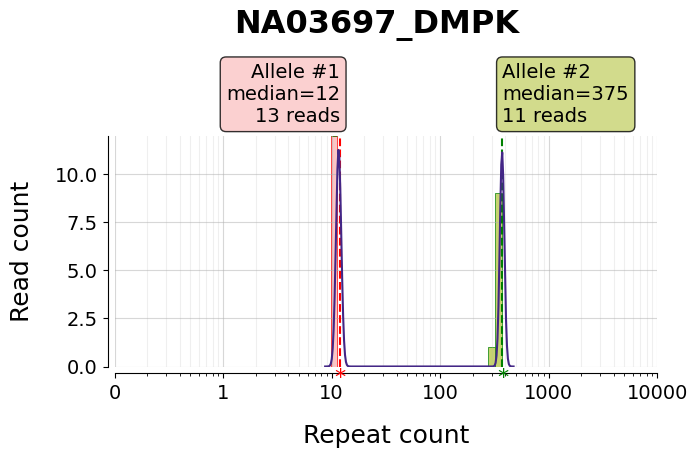

In [23]:
#@title Repeat size estimation

#@markdown - Visualizing distribution of repeat size from the results of running RepeatHMM. \
#@markdown a. The table shows read counts per repeat size. \
#@markdown b. The histogram shows the distribution of repeat size for each allele.

import numpy as np #
import pandas as pd #
import re #
import matplotlib.pyplot as plt #
import matplotlib.ticker as ticker
from sklearn.mixture import GaussianMixture #
import scipy.stats as stats
from scipy import optimize
from itertools import chain


NUM_ALLELES = 2

input_log = rhmm_output
p2hmm_pat = re.compile('INFO: *p2bamhmm (.*)')
logcontent = open(input_log).read()

# Get the sample id
sampleid = sample_name

# Get the gene name and repeat counts
p2hmm_found = p2hmm_pat.search(logcontent)
p2hmminfo = eval(p2hmm_found.groups()[0])
gene = target_gene
repcounts = [
    tuple(map(int, inst.rstrip(',').split(':')))
    for inst in p2hmminfo[3].split(':', 1)[1].split(' ')]
rc = list(chain(*[[length] * count for length, count in repcounts]))
rc = [r for r in rc if r != 0]   # remove 0

# Fit a Gaussian mixture model to the loaded repeat counts
sample_repeats = np.array(rc)
l10_sample_repeats = np.log10(sample_repeats)

def GMM_clustering(l10_sample_repeats, NUM_ALLELES):
    sample_gmm = GaussianMixture(NUM_ALLELES, random_state=1).fit(l10_sample_repeats[:, np.newaxis])
    gmm_labels = np.argsort(sample_gmm.means_.ravel())
    gmmidx2label = {gmmidx: label for label, gmmidx in enumerate(gmm_labels)}
    gmm_means = sample_gmm.means_[gmm_labels]
    pred_labels = np.array([gmmidx2label[p] for p in sample_gmm.predict(l10_sample_repeats[:, np.newaxis])])

    return sample_gmm, gmm_labels, gmmidx2label, gmm_means, pred_labels

sample_gmm, gmm_labels, gmmidx2label, gmm_means, pred_labels = GMM_clustering(l10_sample_repeats, NUM_ALLELES)

label_matched_repeats = []
for repeat, label in zip(l10_sample_repeats, pred_labels):
    label_matched_repeats.append([repeat, label])
round_num = 1

while list(pred_labels).count(0) / len(pred_labels) < 0.1 or list(pred_labels).count(1) / len(pred_labels) < 0.1:
  if list(pred_labels).count(0) / len(pred_labels) < 0.1:
    l10_sample_repeats = np.array([repeat for repeat, label in label_matched_repeats if label == 1])
  elif list(pred_labels).count(1) / len(pred_labels) < 0.1:
    l10_sample_repeats = np.array([repeat for repeat, label in label_matched_repeats if label == 0])
  sample_gmm, gmm_labels, gmmidx2label, gmm_means, pred_labels = GMM_clustering(l10_sample_repeats, NUM_ALLELES)
  label_matched_repeats = []
  for repeat, label in zip(l10_sample_repeats, pred_labels):
    label_matched_repeats.append([repeat, label])
  round_num += 1
  if round_num > 3:
    break

if len(set(pred_labels)) == 1:
    pred_labels = np.array([0] * (len(pred_labels)//2) + [1] * (len(pred_labels) - len(pred_labels)//2))

removed = [l for l in rc if l not in list(np.around(10**l10_sample_repeats).astype(int))]
sample_repeats = list(np.around(10**l10_sample_repeats).astype(int))

# Plotting
BINS = 25
ALLELE_SHADE_COLORS = ['#FBC5C5', '#C7D36F']
ALLELE_MARKER_COLORS = ['#ff0000', '#008000']

LOGPLOT_FOCUS_PCT = 2
LOGPLOT_BAR_MARGIN = 0.1
LOGPLOT_FLANKING_VIEW = 0.05
LOGPLOT_DROP_SPINES = 5
LOGPLOT_PDF_ADDITIONAL_SCALE = 1

fig, ax = plt.subplots(1, 1, figsize=(7, 3))

plt.suptitle('{}_{}'.format(sampleid, gene), y=1.3, fontsize=23, fontweight='bold')
plt.subplots_adjust(wspace=0.4)

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor']='white'

ax.set_xscale('log')

# Set up the ranges to compute histogram and to show
ax_focus = np.percentile(l10_sample_repeats, [LOGPLOT_FOCUS_PCT, 100 - LOGPLOT_FOCUS_PCT])
ax_focuswidth = ax_focus[1] - ax_focus[0]
ax_view = (
    ax_focus[0] - ax_focuswidth * LOGPLOT_FLANKING_VIEW,
    ax_focus[1] + ax_focuswidth * LOGPLOT_FLANKING_VIEW)

# Plot the histogram for each allele and annotate with the stats
prevcount = np.zeros(BINS)
totalreads = len(sample_repeats)
for i, shadecolor, markercolor in zip(range(NUM_ALLELES), ALLELE_SHADE_COLORS, ALLELE_MARKER_COLORS):
    l10counts_allele = l10_sample_repeats[pred_labels == i]
    mediancount = np.around(10 ** np.median(l10counts_allele))

    # Plot histogram
    count, left = np.histogram(l10counts_allele, bins=BINS, range=ax_focus)
    margin = (left[1] - left[0]) * LOGPLOT_BAR_MARGIN
    barleft = 10 ** (left[:-1] + margin/2)
    ax.bar(barleft, count,
            width=10 ** (left[1:] - margin) - barleft,
            color=shadecolor, bottom=prevcount, edgecolor=markercolor, linewidth=.5)
    prevcount = count + prevcount

    # Mark the cluster centers
    ax.axvline(mediancount, c=markercolor, linewidth=1.5, ls='--')
    ax.annotate('*', (mediancount, 0), fontsize=16,
                color=markercolor, ha='center', va='center',
                textcoords='offset points', xytext=(0, -8))
    if i==0:
      ha_loc = 'right'
    elif i==1:
      ha_loc = 'left'
    ax.annotate(f'Allele #{i+1}\nmedian={mediancount:g}\n{len(l10counts_allele):} reads',
                (mediancount, 1), xycoords=('data', 'axes fraction'),
                xytext=(0, 7), textcoords='offset points', ha=ha_loc, va='bottom', fontsize=14,
                bbox={'boxstyle': 'round', 'facecolor': shadecolor, 'alpha': 0.8})

# Find the optimal scaling factor for the dist plot to overlay under the histogram
barcenters = (left[1:] + left[:-1]) / 2
barprobs = np.exp(sample_gmm.score_samples(barcenters[:, None]))
def evaluate_scaling(x):
    return np.sum((prevcount - x * barprobs) ** 2)
prob_scale = optimize.minimize(evaluate_scaling, (1,)).x[0]

# Plot the probability distribution of the GMM
pdf_x = np.linspace(ax_view[0], ax_view[1], 200)
pdf_y = sample_gmm.score_samples(pdf_x.reshape(-1, 1))
ax.plot(10 ** pdf_x, np.exp(pdf_y) * prob_scale * LOGPLOT_PDF_ADDITIONAL_SCALE,
         color='#432686', linewidth=1.5)

# Adjust the aesthetics
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', LOGPLOT_DROP_SPINES))
ax.spines['bottom'].set_position(('outward', LOGPLOT_DROP_SPINES))

ax.grid(which='major', alpha=0.5)
ax.grid(which='minor', alpha=0.2)

ax.set_xlabel('Repeat count', fontsize=18, labelpad=15)
ax.set_ylabel('Read count', fontsize=18, labelpad=15)

# Show the tick labels in the regular number format (not exponential)
if 10**ax_view[1] - 10**ax_view[0] < 100:
  ax.set_xticks(np.arange(np.floor(10**ax_view[0])+1, np.ceil(10**ax_view[1]),np.ceil(np.around(10**ax_view[1] - 10**ax_view[0])/10)+1))
  ticks = ax.get_xticks()
  ax.set_xticklabels(list(map(int, ticks)))
else:
  ticks = ax.get_xticks()
  ax.set_xticks(ticks)
  ax.set_xticklabels(list(map(int, ticks)))

if len(removed) > 0:
  print(f'** NOTICE (outlier existence)\n : {len(removed)} read(s) of {", ".join([str(num) for num in removed])} repeat counts is(are) considered as carryover contamination and eliminated.')

# Format the raw count data for display
output_df = pd.Series(sample_repeats).value_counts().sort_index().reset_index()
output_df.columns = ['Repeat size', 'Read count']
output_df['Allele'] = [
    f'#{gmmidx2label[l] + 1}'
    for l in sample_gmm.predict(np.log10(output_df['Repeat size'].values.reshape(-1, 1)))]
output_df.reset_index(drop=True, inplace=True)
output_df[['Allele', 'Repeat size', 'Read count']]

In [24]:
#@title Repeat structure

#@markdown - You can check the exact sequence and structure of repeats. \
#@markdown - Both unabbreviated form and summarized form show randomly subsampled 30 reads only. \
#@markdown - A summarized form only shows sequences of which length below 25,000 bp. Extremely long sequences are not shown. \
#@markdown - If you want to check all reads' repeats, go and check the file at `repeatlab/analysis/'sample_name'/'sample_name-target_gene'/repeatHMM/'rhmm_result.log'`. \
#@markdown - Repeat structure results might be less accurate with FASTQ input.
#@markdown

#@markdown ####**[ Unabbreviated form ]**

sample_reads = {}

with open(rhmm_output) as f:
    for line in f:
        if line.startswith('INFO: READ:'):
            fragments = line.split(' ')
            if fragments[2] == 'Status:True':
                repeat_count = int(fragments[3][11:])
                if repeat_count != 0:
                  read_id = fragments[1][5:]
                  sequence = fragments[6][7:]
                  pattern = fragments[5][9:]
                  sample_reads[read_id] = [repeat_count, sequence]

sample_reads
sample_reads_df = pd.DataFrame(sample_reads).T.reset_index().sort_values(by=[0])
sample_reads_df.columns = ['read_id', 'repeat_count', 'sequence']
sample_reads_df.reset_index(drop=True, inplace=True)

with open(f'{OUTPUT_DIR_T}/others/repeat_seq.fasta', 'w') as f:
    for i in range(len(sample_reads_df)):
        #f.write('>{}\n{}\n'.format(sample_reads_df.iloc[i]['read_id'], sample_reads_df.iloc[i]['sequence']))
        f.write('>{}\n{}\n'.format('Read_'+str(i+1), sample_reads_df.iloc[i]['sequence']))

from Bio import SeqIO
seqs = list(SeqIO.parse(open(f'{OUTPUT_DIR_T}/others/repeat_seq.fasta'), 'fasta'))
MAXLEN = 1000
longestlen = min(max(len(s.seq) for s in seqs), MAXLEN)
with open(f'{OUTPUT_DIR_T}/others/repeat_seq.fake_aln.fa', 'w') as outf:
  for i, seq in enumerate(seqs):
    print('>' + 'Read_' + str(i+1), file=outf)
    print(str(seq.seq)[:MAXLEN].ljust(longestlen, '-'), file=outf)

from Bio import AlignIO
MAXLEN=1000
fasta_file = AlignIO.read(f'{OUTPUT_DIR_T}/others/repeat_seq.fake_aln.fa', 'fasta')

import sys
from io import StringIO
try:
  sys.stdout, stdoutbackup = StringIO(), sys.stdout
  alv.glimpse(fasta_file, seqtype='dna', width=MAXLEN, n_seq=30)
  ret = sys.stdout.getvalue().splitlines()
  ret[:-1] = sorted(ret[:-1], key=lambda l: int(l.split()[0].split('_')[1]))
finally:
  sys.stdout = stdoutbackup

print('\n'.join(ret))

Read_1  -AGCAGCAGCAGCAGCAGCAGCAGCAGCAG--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
#@markdown ####**[ Summarized form ]**

from Bio import SeqIO
from collections import defaultdict
import re

REPEAT_COLORS = ['\033[96m', # bright cyan
                 '\033[91m', # bright red
                 '\033[92m', # bright green
                 '\033[93m', # bright yellow
                 '\033[94m', # bright blue
                 '\033[95m' # bright magenta
                 ]

def profile_tandem_repeats(seq, kmersize=2):
  kmercounts = defaultdict(int)
  for i in range(len(seq) - kmersize + 1):
    kmer = seq[i:i+kmersize]
    if '^' not in kmer: # Skip over repeat marks
      kmercounts[kmer] += 1
  return kmercounts

pat_repmarks = re.compile('\\([^)]*\\)')

def summarize_tandem_repeats(seq, kmer_short=3, kmer_long=6, minscore=6):
  candidates = []

  seq_wo_repmarks = pat_repmarks.sub('^', seq)
  #print(seq_wo_repmarks)
  for ksize in range(kmer_short, kmer_long + 1):
    kmercounts = profile_tandem_repeats(seq_wo_repmarks, ksize)
    for kmer, count in kmercounts.items():
      if count >= minscore:
        #repoccurrences = re.findall(f'(({kmer}){{2,}})', seq_wo_repmarks)
        repoccurrences = re.findall(f'(({kmer}){{2,}})', seq_wo_repmarks)
        totalreplength = sum(len(full) for full, repunit in repoccurrences)
        if totalreplength >= minscore:
          candidates.append([totalreplength, ksize, kmer])

  if not candidates:
    return seq

  candidates.sort(key=lambda x: (-x[0], x[1]))

  # Replace the occurrences of the first candidate with repeat marks
  repeat = candidates[0][2]
  def replace_repeat(match):
    repcount = len(match.group(0)) // len(repeat)
    if repcount <= 1:
      return match.group(0)
    else:
      return f'({repeat}/{repcount})'

  replaced = re.sub(f'({repeat})+', replace_repeat, seq)
  if replaced == seq:
    return seq
  else:
    return summarize_tandem_repeats(replaced, kmer_short, kmer_long, minscore)

pat_repmarks_full = re.compile('(\\(([^)]*)/(\\d+)\\)|[^()/]+)')

def colorize_repeats(seq):
  # Find all repeats and their occurrences
  repcounts = defaultdict(int)
  for m in pat_repmarks_full.finditer(seq):
    rep, repunit, count = m.groups()
    if repunit is not None:
      repcounts[repunit] += int(count)

  repeats = sorted(repcounts.items(), key=lambda x: (-x[1], x[0]))
  if len(repeats) > len(REPEAT_COLORS):
    REPEAT_COLORS[:] = REPEAT_COLORS * 2 # reuse color scheme for another cycle
  repeatcolors = {rep: color for (rep, cnt), color in zip(repeats, REPEAT_COLORS)}

  outputs = []
  for m in pat_repmarks_full.finditer(seq):
    rep, repunit, count = m.groups()
    if repunit is None or repunit not in repeatcolors:
      outputs.append('\033[90m' + rep + '\033[0m')
    else:
      if int(count) >= 10:
        color = repeatcolors[repunit] #+ '\033[100m'
        # outputs.append('\033[1m' + '(' + color + repunit + '\033[97m' + '/' + count + ')' + '\033[0m')
        outputs.append('\033[1m' + '(' + color + repunit + '\033[0m' + '/' + count + ')' + '\033[0m')
      else:
        #color = '\033[90m'
        color = repeatcolors[repunit]

        # outputs.append('(' + color + repunit + '\033[97m' + '\033[0m'+ '/' + count + ')' + '\033[0m')
        outputs.append('(' + color + repunit + '\033[0m' + '\033[0m'+ '/' + count + ')' + '\033[0m')

  return ''.join(outputs)

turnover = np.bincount(pred_labels)[0]


if len(rc) > 30:
  subsampled_readnum = np.random.choice(len(rc), 30, replace=False)
else:
  subsampled_readnum = np.array([i+1 for i in range(len(rc)-1)])

print('-'*50)
print('|' + ' '*19 + ' Allele 1 ' + ' '*19+ '|')
print('-'*50)

for i, seq in enumerate(SeqIO.parse(open(f'{OUTPUT_DIR_T}/others/repeat_seq.fasta'), 'fasta')):
  if i == turnover:
    print('-'*50)
    print('|' + ' '*19 + ' Allele 2 ' + ' '*19 + '|')
    print('-'*50)
  if len(seq.seq) < 25000 and i+1 in subsampled_readnum:
    #print('I=', seq.seq)
    #print(seq.id)
    sumrep = summarize_tandem_repeats(str(seq.seq).replace('-', ''))
    print(seq.id + '\t' + colorize_repeats(sumrep))
    #print('O=', colorize_repeats(sumrep))




--------------------------------------------------
|                    Allele 1                    |
--------------------------------------------------
Read_1	(AGC/9)AG
Read_2	(CAG/11)
Read_3	(CAG/11)
Read_4	(CAG/11)
Read_5	(CAG/12)
Read_6	(CAG/12)
Read_7	(CAG/12)
Read_8	(CAG/12)
Read_9	(CAG/12)
Read_10	(CAG/12)
Read_11	(CAG/12)
Read_12	(AGC/11)AG
Read_13	(CAG/12)
--------------------------------------------------
|                    Allele 2                    |
--------------------------------------------------
Read_14	(CAG/331)
Read_15	(CAG/207)TAG(CAG/48)TAG(CAG/3)TAG(CAG/103)
Read_16	(CAG/49)CAA(CAG/314)
Read_17	(CAG/73)CAACAGCAA(CAG/147)CAA(CAG/96)CAA(CAG/22)CAA(CAG/25)
Read_18	(CAG/375)
Read_19	(AGC/104)AAA(AGC/75)GGC(AGC/193)AG
Read_20	(CAG/3)CGG(CAG/16)CGG(CAG/16)CAA(CAG/9)CAA(CAG/18)CAA(CAG/4)CAACAGCAA(CAG/2)CAACAGCAA(CAG/5)(CAA/2)CAG(CAA/2)CAG(CAACAG/3)(CAA/3)CAG(CAA/16)CAG(CAACAG/2)(CAA/3)CAG(CAA/2)CAGCAACAG(CAA/3)CAGCAA(CAG/2)CAA(CAG/5)CAACGGCAACAGCAA(CAG/45)CAA(CAG/36)C

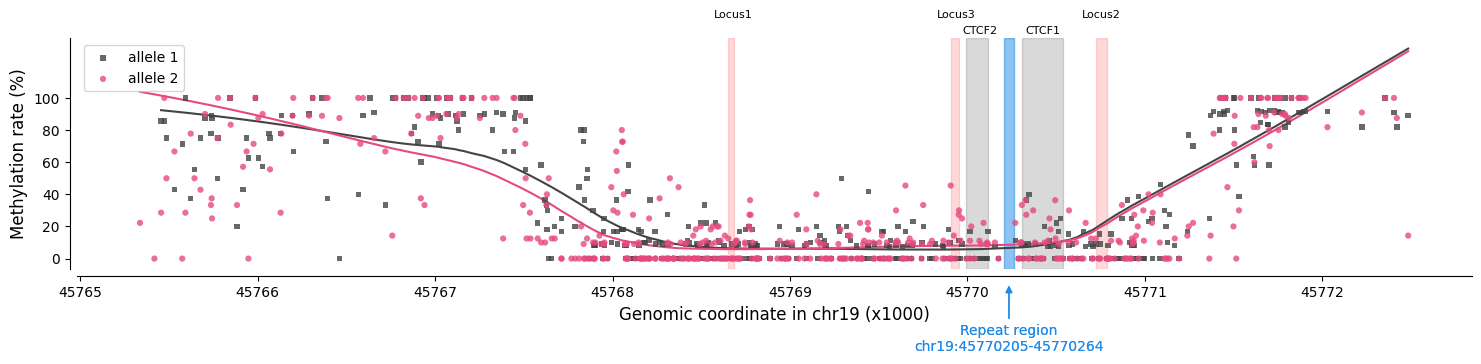

In [26]:
#@title Methylation profiling for each allele

import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.patches as mpatches

if data_type == 'pod5' or data_type == 'fast5':
  allele1_meth_prof = pd.read_csv(allele1_methylation_bed, sep='\t', names=['chr', 'start_pos', 'end_pos', 'modified_base_code', 'score', 'strand', 'start', 'end', 'color', 'N_numbers'])
  allele1_N_numbers = allele1_meth_prof['N_numbers'].str.split(' ', expand=True)
  allele1_N_numbers.columns = ['coverage', 'fraction_modified', 'N_mod', 'N_canonical', 'N_other_mod', 'N_delete', 'N_fail', 'N_diff', 'N_nocall']
  allele1_meth_prof = pd.concat([allele1_meth_prof, allele1_N_numbers], axis=1)
  allele1_meth_prof = allele1_meth_prof.astype({'coverage' : 'int', 'fraction_modified' : 'float'})

  allele2_meth_prof = pd.read_csv(allele2_methylation_bed, sep='\t', names=['chr', 'start_pos', 'end_pos', 'modified_base_code', 'score', 'strand', 'start', 'end', 'color', 'N_numbers'])
  allele2_N_numbers = allele2_meth_prof['N_numbers'].str.split(' ', expand=True)
  allele2_N_numbers.columns = ['coverage', 'fraction_modified', 'N_mod', 'N_canonical', 'N_other_mod', 'N_delete', 'N_fail', 'N_diff', 'N_nocall']
  allele2_meth_prof = pd.concat([allele2_meth_prof, allele2_N_numbers], axis=1)
  allele2_meth_prof = allele2_meth_prof.astype({'coverage' : 'int', 'fraction_modified' : 'float'})

  allele1_meth_prof, allele2_meth_prof = allele1_meth_prof[allele1_meth_prof['coverage'] > 5], allele2_meth_prof[allele2_meth_prof['coverage'] > 5]

  if methylation_key_positions != "":
    meth_key_groups = methylation_key_positions.split(" ")
    meth_keys = []
    for group in meth_key_groups:
      meth_keys.append(list(map(int, group.split(","))))
  if target_gene == 'DMPK':
    CTCF1_sites = [int(site) for site in CTCF1_positions.split(",")]
    CTCF2_sites = [int(site) for site in CTCF2_positions.split(",")]


  DISCRETE_COLOR_LEVELS = 10
  _cmap = mpl.cm.get_cmap('YlGnBu')
  _cmap.set_gamma(0.6)
  sitemarkers_cmap = mpl.colors.LinearSegmentedColormap.from_list(
      'mycolormap', _cmap(np.linspace(0, 1, DISCRETE_COLOR_LEVELS)),
      DISCRETE_COLOR_LEVELS)

  ALLELE1_COLOR = '#444444'
  ALLELE2_COLOR = '#e64980'

  def plot_methylation_with_trend(ax, meth_prof, color, marker, allele, repeat_region):
    ax.scatter(meth_prof['start_pos'], meth_prof['fraction_modified'], zorder=6,
                edgecolor='none', facecolor=color,
                s={'s': 15, 'o': 20}[marker], alpha=.8,
                marker=marker, label=allele)

    trend = sm.nonparametric.lowess(exog=meth_prof['start_pos'], endog=meth_prof['fraction_modified'], frac=0.4)
    ax.plot(trend[:,0], trend[:,1], c=color, linewidth=1.5, linestyle='-', zorder=4)
    ax.set_xticks(ax.get_xticks())
    ax.set_yticks(np.arange(0,120,20))
    ax.set_xticklabels((ax.get_xticks()/1000).astype(int), size=12)
    ax.set_yticklabels(np.arange(0,120,20), size=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_position(('outward', LOGPLOT_DROP_SPINES))
    ax.spines['bottom'].set_position(('outward', LOGPLOT_DROP_SPINES))
    ax.legend()
    target_chr = repeat_region.split(':')[0]
    repeat_window = repeat_region.split(':')[1].split('-')
    repeat_start, repeat_end = int(repeat_window[0]), int(repeat_window[1])
    repeat_length = repeat_end - repeat_start
    ax.axvspan(repeat_start, repeat_end, alpha=0.3, color='#228be6')
    ax.annotate(f'Repeat region\n{repeat_region}', xy=(repeat_start+repeat_length/2, -15), xytext=(repeat_start+repeat_length/2, -50), ha='center', va='center', color='#228be6', annotation_clip=False, arrowprops=dict(arrowstyle=mpatches.ArrowStyle('-|>'), fc='#228be6', ec='#228be6'))
    ax.set_xlabel(f'Genomic coordinate in {target_chr} (x1000)', size=12)
    ax.set_ylabel('Methylation rate (%)', size=12)

  fig, ax = plt.subplots(1,1, figsize=(18,3))

  plot_methylation_with_trend(ax, allele1_meth_prof, ALLELE1_COLOR, 's', 'allele 1', target_region)
  plot_methylation_with_trend(ax, allele2_meth_prof, ALLELE2_COLOR, 'o', 'allele 2', target_region)

  if len(meth_keys) > 0:
    for i, group in enumerate(meth_keys):
      ax.axvspan(np.min(group), np.max(group), alpha=0.15, color='red')
      ax.text(np.min(group)-80, 150, f'Locus{i+1}', fontsize=8)
  if target_gene == 'DMPK':
    ax.axvspan(np.min(CTCF1_sites), np.max(CTCF1_sites), alpha=0.15, color='black')
    ax.axvspan(np.min(CTCF2_sites), np.max(CTCF2_sites), alpha=0.15, color='black')
    ax.text(np.min(CTCF1_sites)+20, 140, 'CTCF1', fontsize=8)
    ax.text(np.min(CTCF2_sites)-20, 140, 'CTCF2', fontsize=8)

elif data_type == 'fastq':
  print('FASTQ input does not offer methylation profiling.')

,CTCF1,CTCF2,Locus1,Locus2,Locus3
Allele1,9.5344,3.030909,3.030000,5.593333,1.851667
Allele2,10.3680,9.246364,3.598333,2.083333,19.501667


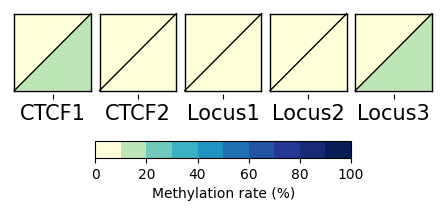

In [27]:
#@markdown - Profiles for key regions.

if target_gene == 'DMPK':
  a1_CTCF1_meth_mean = np.mean(allele1_meth_prof.loc[allele1_meth_prof['start_pos'].isin(CTCF1_sites), 'fraction_modified'].tolist())
  a1_CTCF2_meth_mean = np.mean(allele1_meth_prof.loc[allele1_meth_prof['start_pos'].isin(CTCF2_sites), 'fraction_modified'].tolist())
  a1_g1_meth_mean = np.mean(allele1_meth_prof.loc[allele1_meth_prof['start_pos'].isin(meth_keys[0]), 'fraction_modified'].tolist())
  a1_g2_meth_mean = np.mean(allele1_meth_prof.loc[allele1_meth_prof['start_pos'].isin(meth_keys[1]), 'fraction_modified'].tolist())
  a1_g3_meth_mean = np.mean(allele1_meth_prof.loc[allele1_meth_prof['start_pos'].isin(meth_keys[2]), 'fraction_modified'].tolist())

  a2_CTCF1_meth_mean = np.mean(allele2_meth_prof.loc[allele2_meth_prof['start_pos'].isin(CTCF1_sites), 'fraction_modified'].tolist())
  a2_CTCF2_meth_mean = np.mean(allele2_meth_prof.loc[allele2_meth_prof['start_pos'].isin(CTCF2_sites), 'fraction_modified'].tolist())
  a2_g1_meth_mean = np.mean(allele2_meth_prof.loc[allele2_meth_prof['start_pos'].isin(meth_keys[0]), 'fraction_modified'].tolist())
  a2_g2_meth_mean = np.mean(allele2_meth_prof.loc[allele2_meth_prof['start_pos'].isin(meth_keys[1]), 'fraction_modified'].tolist())
  a2_g3_meth_mean = np.mean(allele2_meth_prof.loc[allele2_meth_prof['start_pos'].isin(meth_keys[2]), 'fraction_modified'].tolist())

  a1_keys_meth_mean = np.array([a1_CTCF1_meth_mean, a1_CTCF2_meth_mean, a1_g1_meth_mean, a1_g2_meth_mean, a1_g3_meth_mean])
  a2_keys_meth_mean = np.array([a2_CTCF1_meth_mean, a2_CTCF2_meth_mean, a2_g1_meth_mean, a2_g2_meth_mean, a2_g3_meth_mean])

elif len(meth_keys) > 0:
  a1_keys_meth_mean = []
  a2_keys_meth_mean = []
  for key in meth_keys:
    a1_keys_meth_mean.append(np.mean(allele1_meth_prof.loc[allele1_meth_prof['start_pos'].isin(key), 'fraction_modified'].tolist()))
    a2_keys_meth_mean.append(np.mean(allele2_meth_prof.loc[allele2_meth_prof['start_pos'].isin(key), 'fraction_modified'].tolist()))
  a1_keys_meth_mean = np.array(a1_keys_meth_mean)
  a2_keys_meth_mean = np.array(a2_keys_meth_mean)

else:
  print('No methylation key regions.')

if len(a1_keys_meth_mean) > 0 and len(a2_keys_meth_mean) > 0:
  from matplotlib.patches import Polygon
  from matplotlib.colors import Normalize
  import matplotlib.cm as cm

  DISCRETE_COLOR_LEVELS = 10
  _cmap = plt.get_cmap('YlGnBu').copy()
  _cmap.set_gamma(0.6)
  _cmap = mpl.colors.LinearSegmentedColormap.from_list(
      'mycolormap', _cmap(np.linspace(0, 1, DISCRETE_COLOR_LEVELS)),
      DISCRETE_COLOR_LEVELS)
  cmap_top = _cmap
  cmap_bottom = _cmap

  norm_top = Normalize(vmin=0, vmax=100)
  norm_bottom = Normalize(vmin=0, vmax=100)

  fig, ax = plt.subplots(1, 1, figsize=(5.5,2))

  gap = 0.05

  for i in range(len(a1_keys_meth_mean)):
    x_left, x_right = i+gap, i+1-gap
    y_bottom, y_top = 0, 1

    coords_top_left = [(x_left, y_top), (x_left, y_bottom), (x_right, y_bottom)]
    coords_bottom_right = [(x_right, y_top), (x_left, y_top), (x_right, y_bottom)]

    poly_top = Polygon(coords_top_left, closed=True)
    poly_bottom = Polygon(coords_bottom_right, closed=True)

    val_top = a1_keys_meth_mean[i]
    val_bottom = a2_keys_meth_mean[i]

    poly_top.set_facecolor(cmap_top(norm_top(val_top)))
    poly_bottom.set_facecolor(cmap_bottom(norm_bottom(val_bottom)))

    poly_top.set_edgecolor('none')
    poly_bottom.set_edgecolor('none')

    ax.add_patch(poly_top)
    ax.add_patch(poly_bottom)

    linewidth=1
    ax.plot([i+gap, i+1-gap], [1, 0], color='black', linewidth=linewidth, zorder=3)

    ax.plot([i+gap, i+gap], [0, 1], color='black', linewidth=linewidth, zorder=3)
    ax.plot([i+1-gap, i+1-gap], [0, 1], color='black', linewidth=linewidth, zorder=3)
    ax.plot([i+gap, i+1-gap], [0, 0], color='black', linewidth=linewidth, zorder=3)
    ax.plot([i+gap, i+1-gap], [1, 1], color='black', linewidth=linewidth, zorder=3)

  ax.set_xlim(0, len(a1_keys_meth_mean))
  ax.invert_yaxis()
  ax.set_yticks([])

  for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_visible(False)

  sm_top = cm.ScalarMappable(norm=norm_top, cmap=cmap_top)
  cbar = plt.colorbar(sm_top, ax=ax, location='bottom', pad=0.3, aspect=15, shrink=0.6)
  cbar.set_label('Methylation rate (%)', fontsize=10)

  ax.set_xticks(np.arange(len(a1_keys_meth_mean)) + 0.5)
  if target_gene == 'DMPK':
    labels = ['CTCF1', 'CTCF2', 'Locus1', 'Locus2', 'Locus3']
    ax.set_xticklabels(labels, fontsize=15)
  else:
    labels = [f'Locus{i+1}' for i in range(len(a1_keys_meth_mean))]
    ax.set_xticklabels(labels, fontsize=15)
pd.DataFrame([a1_keys_meth_mean, a2_keys_meth_mean], columns=labels, index=['Allele1', 'Allele2'])

# Instructions <a name="Instructions"></a>

##**Quick start**
#### --> Follow <a href="#Quick Start">⭐ stars </a>at the top of the notebook.
####1. Copy the folder containing POD5, FAST5, or FASTQ files into your Google Drive, and input the location in the Drive.
####2. Write down your sample name and target gene name. Sample name will be printed in your report.
####3. Click the button `Runtime` tab > `Run all` (or just hit '`command`/`control` + `F9`' as keyboard shortcut).
\

##**Analysis results**
####1. You can check analysis results at the <a href="#Results"> Results</a> section in this notebook.
####2. After RepeatLab has finished running, you could find a folder named `repeatlab` under `MyDrive` in your Google Drive. Analysis output files are in the directory `repeatlab/analysis/{sample_name}`.


\

##**Troubleshooting**
####1. Check if you turned on the GPU. (`Runtime` tab > `Change runtime type` > `Hardware accelerator` > Check if `T4 GPU` turned on.)
####2. Check your Google Drive storage is enough. (minimum 8GB is needed.)
####3. We do not recommend empty spaces within the input file path name.
  (e.g. Please change the folder name from `'Data directory/Data'` to `'Data_directory/Data'`)
####4. If you encounter any errors using RepeatLab, please report the trouble issues at https://github.com/ChangLabSNU/repeat-expansion-diagnosis/issues.

